In [1]:
import utils
import math
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
df = pd.read_csv('/Users/allen/Documents/data_512/Data/call_data_filtered.csv')

df['Original Time Queued'] = pd.to_datetime(df['Original Time Queued'])

# Features

In [3]:
ds = df.copy()

In [4]:
ds['Call_Hour'] = ds['Original Time Queued'].dt.hour
ds['Call_Weekday'] = ds['Original Time Queued'].dt.weekday

ds['Call_Hour_Bin'] = ds['Call_Hour'].apply(utils.create_hour_bin)


# extract holiday info
cal = calendar()
holidays = cal.holidays(start=ds['Original Time Queued'].min(), end=ds['Original Time Queued'].max())
ds['is_Holiday'] = ds['Original Time Queued'].dt.date.isin(pd.Series(holidays).dt.date).astype(int)

# encoding
ds = ds[['Call Type','Priority','Precinct','Sector','response_time','Call_Weekday','Call_Hour_Bin','is_Holiday']]

ds = pd.get_dummies(ds, 
               columns=['Call Type','Priority','Precinct','Sector','Call_Weekday','Call_Hour_Bin'],
               prefix=['Call Type','Priority','Precinct','Sector','Call_Weekday','Call_Hour_Bin'])

# Train and Validation

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(ds.drop(columns=['response_time']),
                                                  ds['response_time'],
                                                  test_size=0.2, 
                                                  random_state=10)

# Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
forest_reg = RandomForestRegressor(n_estimators=20, random_state=10,
                                  min_samples_leaf=10)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [30]:
pred_forest = forest_reg.predict(X_val)
math.sqrt(((y_val - pred_forest)**2).mean())

13.242597998848613

In [ ]:
# param_grid = [{'max_depth': [10, 20, 30],
#                'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
#                'n_estimators': [100, 200, 400]}]

# forest_clf = RandomForestRegressor(n_estimators=20, random_state=10)

# grid_search_full = GridSearchCV(forest_clf, param_grid, cv=3, verbose=3, n_jobs=-1)
# grid_search_full.fit(X, y)

# Xgboost

In [37]:
import xgboost as xgb

In [43]:
dtrain = xgb.DMatrix(X_train, label=y_train.to_numpy())
dval = xgb.DMatrix(X_val, label=y_val.to_numpy())

In [46]:
param = {
    'objective': 'reg:squarederror',
    'eva_metric': 'rmse',
    'eta': 0.1,
    'subsample': 0.8,
    'colsample': 0.8,
    'max_depth': 6
}

num_round = 5

In [47]:
# specify validations set to watch performance
watchlist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, 
                dtrain, 
                num_round,
                watchlist,
                early_stopping_rounds=10)

[0]	eval-rmse:20.2477	train-rmse:20.1488
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:19.1254	train-rmse:19.0262
[2]	eval-rmse:18.1644	train-rmse:18.0654
[3]	eval-rmse:17.3465	train-rmse:17.2485
[4]	eval-rmse:16.6543	train-rmse:16.5583


In [57]:
imp = pd.DataFrame.from_dict(bst.get_score(importance_type='gain'), orient='index', columns=['feature']) \
    .sort_values('feature', ascending=False)

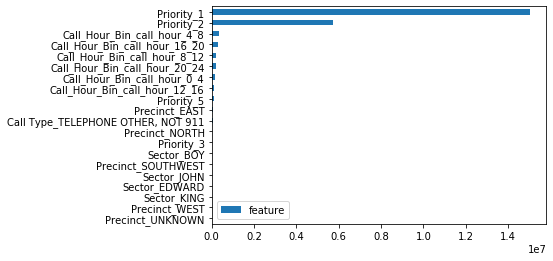

In [70]:
imp.head(20).sort_values('feature').plot.barh();

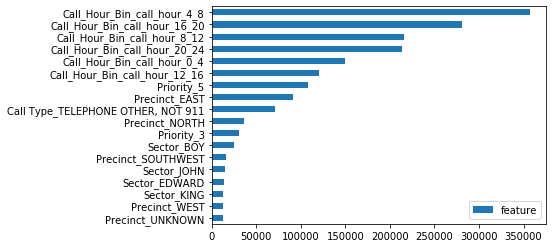

In [87]:
imp.iloc[2:20,:].sort_values('feature').plot.barh();

In [14]:
bst = xgb.Booster()  # init model
bst.load_model('bst.model')  

In [15]:
pred = bst.predict(dval)

In [17]:
math.sqrt(((y_val - pred)**2).mean())

13.20815092896975